# Optical Flow

In [1]:
import numpy as np
import numba as nb
import cv2
import matplotlib.pyplot as plt
from utils import plots
from utils import imgs
from skimage.util.shape import view_as_windows
from tqdm import tqdm
from scipy import ndimage

In [2]:
# I(x,y)
I1, I2 = cv2.imread('images/yos08.pgm', 0) / 255.0, cv2.imread('images/yos09.pgm', 0) / 255.0

gt = np.genfromtxt('images/yos_co.txt')

### Lucas-Kanade Method

In [58]:
def lucas_kanade2(I1, I2, n=9):
    
    # Neighborhood size
    k = cv2.getGaussianKernel(n, -1)
    k = k @ k.T
    n = np.array([n, n])
    
    Iy, Ix, It = np.stack(np.gradient(np.stack([I1, I2], axis=-1)), axis=0)[..., 0].copy()
    Iy, Ix, It = map(lambda x: view_as_windows(np.pad(x, [n//2, n//2], 'reflect'), n), [Iy, Ix, It])
    
    # Formulate system
    A = np.array([[Ix * Ix, Ix * Iy], [Ix * Iy, Iy * Iy]]).transpose([2, 3, 0, 1, 4, 5])
    b = np.array([[-Ix * It], [-Iy * It]]).transpose([2, 3, 0, 1, 4, 5])
    
    # Apply Gaussian Kernel to weigh the neighborhood
    A = (k * A).sum(axis=(-1, -2))
    b = (k * b).sum(axis=(-1, -2))
    
    # Solve when is determined
    flow = np.zeros((*I1.shape, 2))
    rank = np.linalg.matrix_rank(A)==2
    flow[rank] = np.linalg.solve(A[rank], b[rank])[:, :, 0]
    
    return flow

In [59]:
def lucas_kanade2_lstsq(I1, I2, n=9):
    
    # Neighborhood size
    k = cv2.getGaussianKernel(n, -1)
    k = k @ k.T
    n = np.array([n, n])
    
    Iy, Ix, It = np.stack(np.gradient(np.stack([I1, I2], axis=-1)), axis=0)[..., 0].copy()
    Iy, Ix, It = map(lambda x: view_as_windows(np.pad(x, [n//2, n//2], 'reflect'), n), [Iy, Ix, It])
    
    # Formulate system
    A = np.stack([k * Ix, k * Iy], axis=-1).reshape([-1, n.prod(), 2])
    b = -(k * It).reshape([-1, n.prod()])
    
    
    solve = lambda a, b: np.linalg.lstsq(a, b, rcond=None)[0]
    
    r = np.vectorize(solve, signature='(j,k),(j)->(k)')(A, b)
    
    return r.reshape((*I1.shape, 2))

In [ ]:
neig = 39
size = 7

I1_gauss, I2_gauss = cv2.GaussianBlur(I1, (size, size),0), cv2.GaussianBlur(I2,(size, size),0)
flow_lucas = lucas_kanade2(I1_gauss, I2_gauss, neig)

plt.title('AAE: {0:.2f}'.format(imgs.aae(gt, flow_lucas.reshape((-1, 2)))))
plt.imshow(imgs.flow2image(flow_lucas))
plt.show()

### Horn-Schunck Gradient Descent

In [13]:
def horn_schunk(I1, I2, init_flow=None, alpha=1.0, n=10, tau=0.01):    
    
    init_flow = np.zeros((*I1.shape, 2)) if init_flow is None else init_flow
    u = init_flow[..., 0].copy()
    v = init_flow[..., 1].copy()
    
    # Gradients
    Iy, Ix, It = np.stack(np.gradient(np.stack([I1, I2], axis=-1)), axis=0)[..., 0].copy()
    
    for it in tqdm(range(n)):
        u = u - tau * ((Ix*u + Iy*v + It) * Ix - alpha * ndimage.laplace(u))
        v = v - tau * ((Ix*u + Iy*v + It) * Iy - alpha * ndimage.laplace(v))
        
    return np.stack([u, v], axis=-1)

100%|██████████| 10001/10001 [00:37<00:00, 264.33it/s]


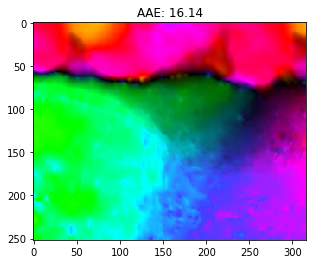

In [18]:
size = 7
n_iter = 10000

I1_gauss, I2_gauss = cv2.GaussianBlur(I1, (size, size),0), cv2.GaussianBlur(I2,(size, size),0)
flow = horn_schunk(I1_gauss, I2_gauss, init_flow=flow, alpha=1.0 / 125.0, n=n_iter+1, tau=1.0)

plt.title('AAE: {0:.2f}'.format(imgs.aae(gt, flow.reshape((-1, 2)))))
plt.imshow(imgs.flow2image(flow))
plt.show()


In [24]:
def horn_schunk_robust(I1, I2, init_flow=None, alpha=1.0, n=10, tau=0.01):    
    
    init_flow = np.zeros((*I1.shape, 2)) if init_flow is None else init_flow
    u = init_flow[..., 0].copy()
    v = init_flow[..., 1].copy()
    
    # Gradients
    Iy, Ix, It = np.stack(np.gradient(np.stack([I1, I2], axis=-1)), axis=0)[..., 0].copy()
    
    pot = lambda x: 1.0 / (2.0 * np.sqrt(x + 0.001**2))
    
    for it in tqdm(range(n)):
        
        dterm = (Ix*u + Iy*v + It)
        
        gradu = np.stack(np.gradient(u), axis=-1)
        gradv = np.stack(np.gradient(v), axis=-1)
        
        stermu = pot(np.linalg.norm(gradu, axis=-1)**2)
        stermv = pot(np.linalg.norm(gradv, axis=-1)**2)
        
        u = u - tau * (pot(dterm**2) * dterm * Ix - alpha * imgs.div(stermu[..., None] * gradu))
        v = v - tau * (pot(dterm**2) * dterm * Iy - alpha * imgs.div(stermv[..., None] * gradv))
        
    return np.stack([u, v], axis=-1)

100%|██████████| 10001/10001 [02:23<00:00, 69.72it/s]


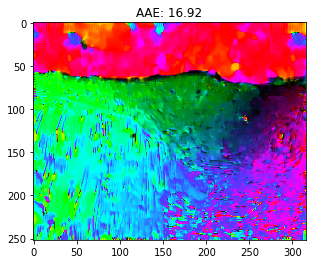

In [29]:
size = 7
n_iter = 10000

I1_gauss, I2_gauss = cv2.GaussianBlur(I1, (size, size),0), cv2.GaussianBlur(I2,(size, size),0)
flow = horn_schunk_robust(I1_gauss, I2_gauss, init_flow=flow_lucas, alpha=1.0 / 125.0, n=n_iter+1, tau=1.0)

plt.title('AAE: {0:.2f}'.format(imgs.aae(gt, flow.reshape((-1, 2)))))
plt.imshow(imgs.flow2image(flow))
plt.show()
